In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pylab as pl
from IPython import display

### Generate sample data, with added gaussian noise

In [2]:
N = 20#Number of points
X = np.random.uniform(-1,1,N)
Y = -0.3 + 0.5*X + np.random.normal(0,0.2,N)

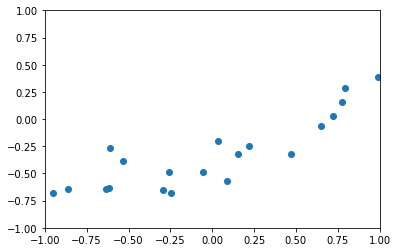

In [3]:
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.plot(X,Y,'o')
#plt.plot([0,10], [0,10], 'go-', label='line 1', linewidth=2)

[Text(0, 0, ' -1.00'),
 Text(0, 0, ' -0.50'),
 Text(0, 0, '  0.00'),
 Text(0, 0, '  0.50'),
 Text(0, 0, '  1.00')]

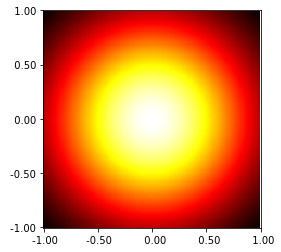

In [4]:
from scipy.stats import multivariate_normal
rv = multivariate_normal([0., 0.], [[0.5, 0], [0, 0.5]])
#Let us assume the weights in range(-1,1).
#The 2d grid -1 to 1 in both x and y directions is to visualize the pdf of weights
Grid_size = 200
a = np.linspace(-1,1,Grid_size)
W0, W1 = np.meshgrid(a,a)
pos = np.empty(W0.shape + (2,))
pos[:, :, 0] = W0; pos[:, :, 1] = W1
fig,(ax1) = plt.subplots(1)

ax1.imshow(rv.pdf(pos), cmap='hot', interpolation='nearest', origin='lower')

ticks = np.linspace(0,Grid_size,5)

ticklabels = ["{:6.2f}".format(i) for i in 2*ticks/Grid_size-1]

#manually setting the ticks 

ax1.set_xticks(ticks)

ax1.set_xticklabels(ticklabels)
ax1.set_yticks(ticks)
ax1.set_yticklabels(ticklabels)

#plt.show()


## Gaussian log likelihood is calculated as below


### 1. $\log p(y|w,\sigma^2) = \Sigma_{n=1}^{N} \log \mathrm{N}(y_n|w^TX,\sigma^2) $


### 2. $\log p(y|w,\sigma^2) = -\frac{N}{2} \log \sigma^2 - \frac{N}{2}\log (2\pi)-\frac{E_{D}(w)}{\sigma^2}$

### 3.  $E_{D}(w) = \frac{1}{2} \Sigma_{n=1}^{N} (y_n - w^Tx_n)^2$

In [5]:
def likelihood(w0,w1,x,y,like_precision):    
    n = x.shape[0]
    logp = n/2.0*np.log(25) - n/2.0*np.log(2*np.pi) - like_precision* np.sum(np.power(y - (w1*x+w0),2))/(2.0)
    return logp


In [6]:
W0_temp = W0.reshape(Grid_size*Grid_size,1)
W1_temp = W1.reshape(Grid_size*Grid_size,1)
    
def plot_map_likelihood(x,y,like_precision):    
    i = 0
    likeli = np.zeros((Grid_size*Grid_size,1))
    fig,(ax3) = plt.subplots(1)
    for w0,w1 in  zip(W0_temp,W1_temp):
        #or w1 in W1.reshape(Grid_size*Grid_size,1):
        likeli[i][0] = likelihood(w0,w1,x,y,like_precision)
        i = i+1
    likeli = likeli.reshape(Grid_size,Grid_size)
    pos = np.empty(W0.shape + (2,))
    pos[:, :, 0] = W0; pos[:, :, 1] = W1
    
    Max = np.max(likeli)
    Min = np.min(likeli)
    likeli = (likeli - Min)/(Max - Min)
    Thresh = 0.85
    Index = likeli<Thresh
    likeli[Index] =  0
    
    Max = np.max(likeli)
    Min = np.min(likeli)
    #likeli = 100*(likeli - Min)/(Max - Min)
    
    
    ax3.imshow(likeli, cmap='hot', interpolation='nearest', origin='lower')
    ticks = np.linspace(0,Grid_size,5)
    ticklabels = ["{:6.2f}".format(i) for i in 2*ticks/Grid_size-1]
    ax3.set_xticks(ticks)
    ax3.set_xticklabels(ticklabels)
    ax3.set_yticks(ticks)
    ax3.set_yticklabels(ticklabels)
    m = np.argmax(likeli)
    r = m//Grid_size
    c = m%Grid_size
    ax3.plot(c,r,'x')
    ax3.set_title('likelihood', fontdict={'fontsize': 15, 'fontweight': 'medium'})
    #plt.show()

###  Function, plot_map plots the images showing the importance of parameters after observing every sample.

In [7]:

def plot_map(mean,cov,X_train,like_precision,x=None,y=None,posterior=False):
    if posterior==True:
        plot_map_likelihood(x,y,like_precision) 
    rv = multivariate_normal(mean, cov)
    fig,(ax1,ax2) = plt.subplots(1,2)
    ax1.imshow(rv.pdf(pos), cmap='hot', interpolation='nearest', origin='lower')
    ticks = np.linspace(0,Grid_size,5)
    # What those pixel locations correspond to in data coordinates.
    # Also set the float format here
    ticklabels = ["{:6.2f}".format(i) for i in 2*ticks/Grid_size-1]
    ax1.set_xticks(ticks)
    ax1.set_xticklabels(ticklabels)
    ax1.set_yticks(ticks)
    ax1.set_yticklabels(ticklabels)
    ax2.set_ylim([-1,1])
    ax2.set_xlim([-1,1])
   
    ax2.set_title('Randomly sampled lines', fontdict={'fontsize': 15, 'fontweight': 'medium'})
    #Draw lines
    Num_lines = 25
    w0, w1 = np.random.multivariate_normal(mean, cov, Num_lines).T
    for i in range(Num_lines):
        ax2.plot(X_train,w1[i]*X_train + w0[i],'r')
    if posterior==True:
        ax2.plot(x,y,'o')
        ax1.set_title('Posterior', fontdict={'fontsize': 15, 'fontweight': 'medium'})
    else:
        ax1.set_title('Prior ', fontdict={'fontsize': 15, 'fontweight': 'medium'})
        

### Here the posterior over the parameters is updated after observing every sample. 
#### 1. Updated covariance matrix
$\Sigma_{post} = [\Sigma_{prior}^{-1} + \beta X^T X]^{-1}$


#### 2. Updated mean vector
$\mu_{post} = \Sigma_{post} ( \Sigma_{prior}^{-1} \mu_{prior} + \beta X^T t) $

$ \beta $ is the precision(inverse of variance) of likelihood, $X$ is the input matrix of size $mxd$, $t$ is column vector representing the corresponding outputs of each input vector in $X$

[[ 1.         -0.85897028]] [-0.64119058]
[[1.         0.72357256]] [0.02501934]
[[ 1.         -0.24503321]] [-0.68216812]
[[ 1.         -0.61458715]] [-0.63316267]
[[1.         0.15108589]] [-0.31750364]
[[1.         0.64926951]] [-0.06648584]
[[ 1.        -0.2558849]] [-0.48475402]
[[1.         0.46821515]] [-0.32475046]
[[1.         0.08890831]] [-0.5694858]
[[1.         0.77697268]] [0.15839885]


/home/srinivas/DSVI/lib/python3.5/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[[1.         0.03627611]] [-0.19918459]
[[ 1.         -0.61047802]] [-0.26815015]
[[1.         0.99156409]] [0.38313227]
[[1.        0.7931714]] [0.28485967]
[[1.         0.22014269]] [-0.24995709]
[[ 1.         -0.95112897]] [-0.67805667]
[[ 1.         -0.53274944]] [-0.38979074]
[[ 1.         -0.29512754]] [-0.65510779]
[[ 1.         -0.05369437]] [-0.48697703]
[[ 1.         -0.63199628]] [-0.64016153]


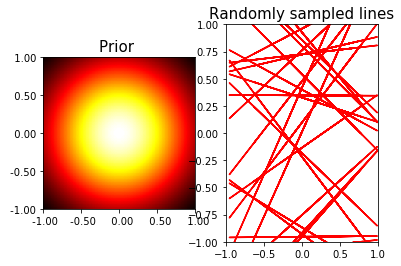

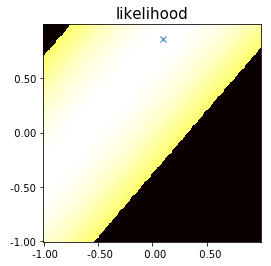

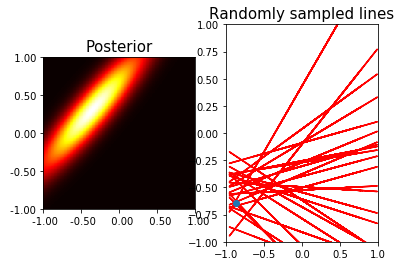

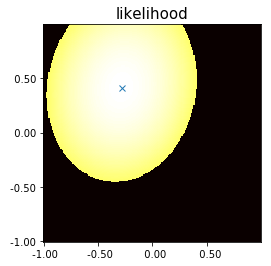

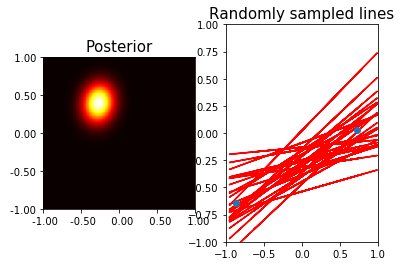

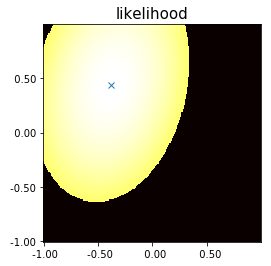

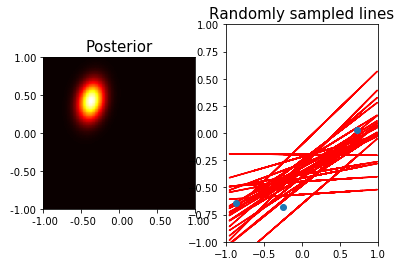

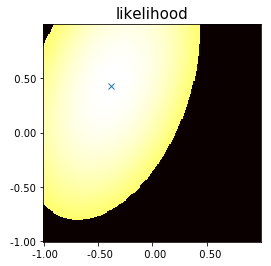

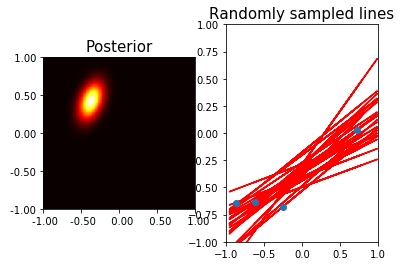

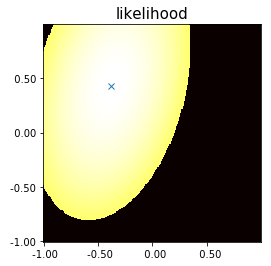

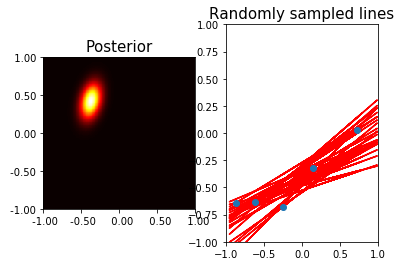

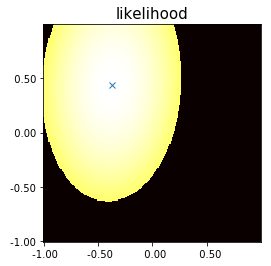

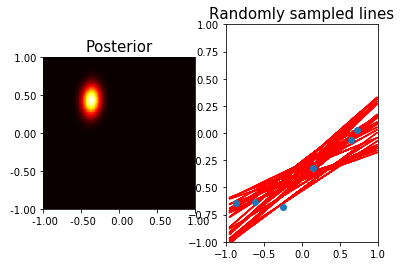

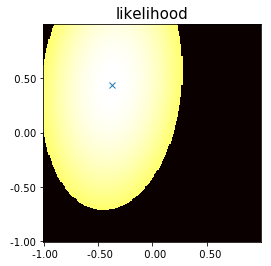

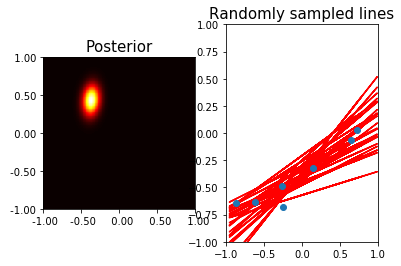

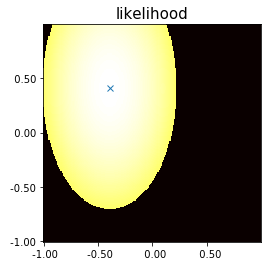

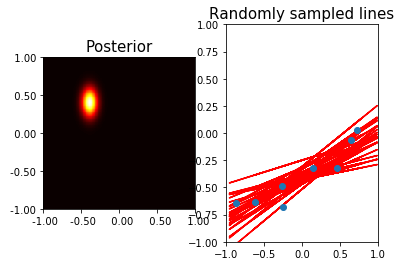

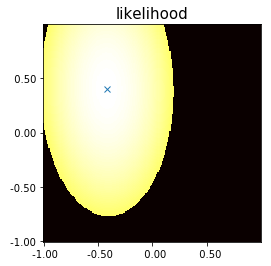

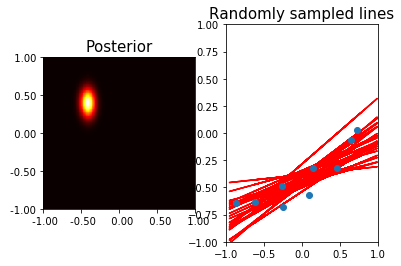

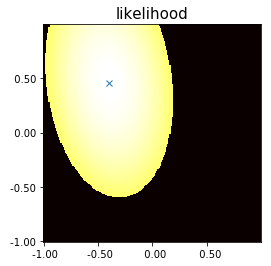

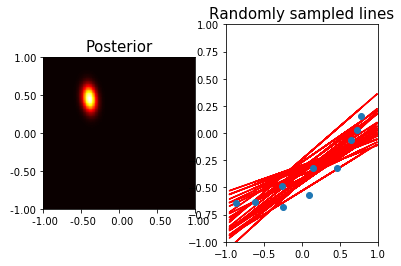

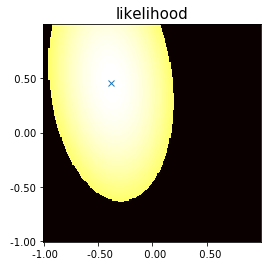

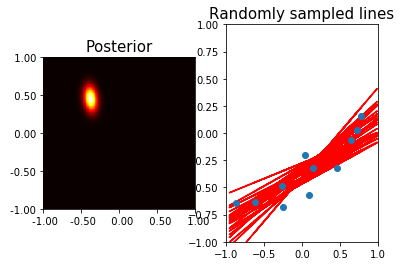

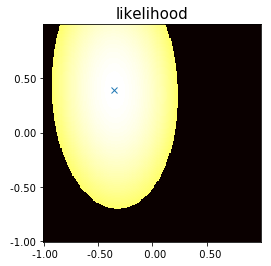

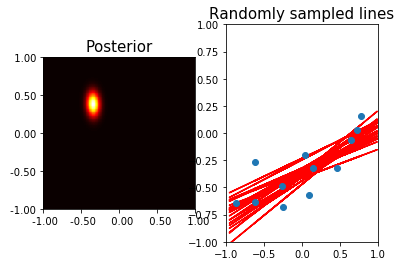

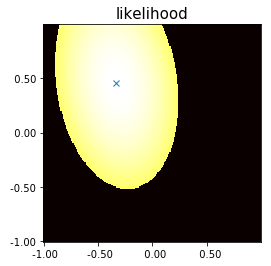

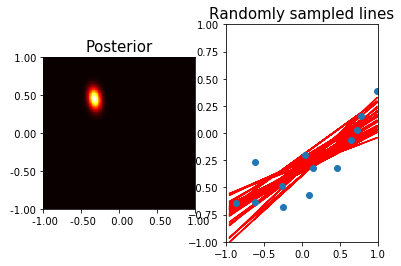

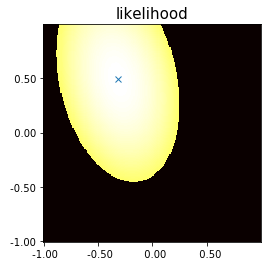

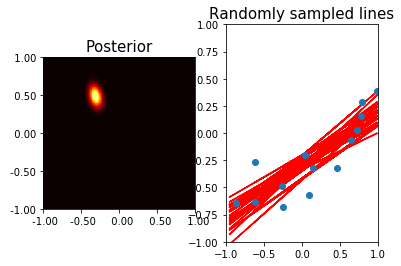

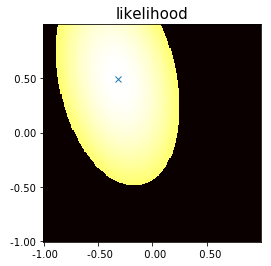

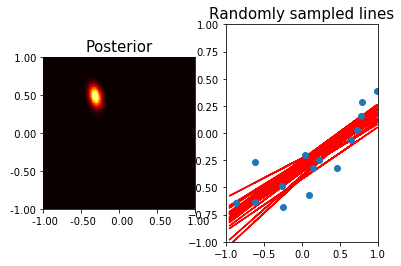

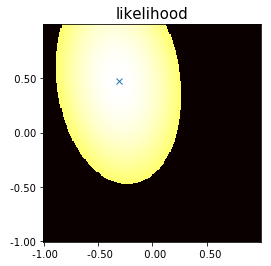

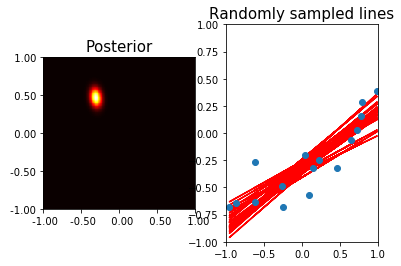

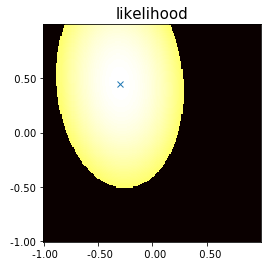

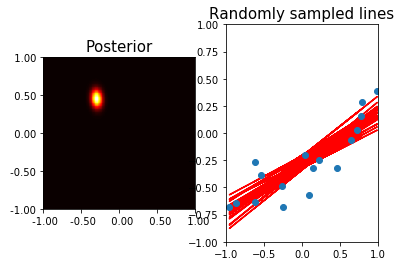

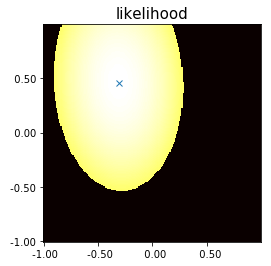

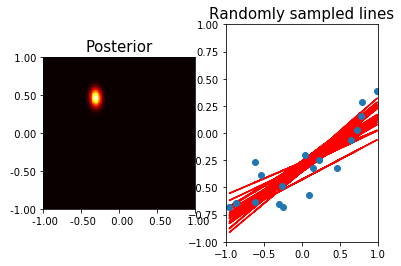

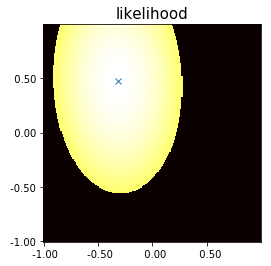

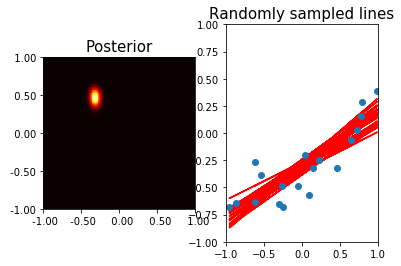

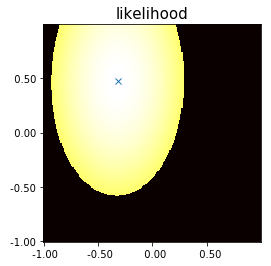

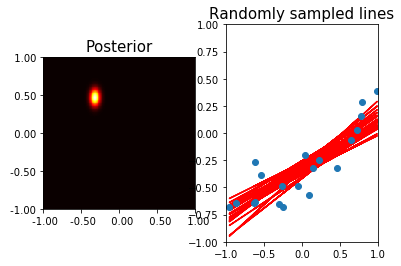

In [8]:
prior_mean = np.array([0,0])
prior_cov = np.array([[0.5, 0], [0, 0.5]])

like_var = 0.2
like_precision = np.power(1/like_var,2)
X_train = np.ones((N,2))
X_train[:,1] = X
Y_train = Y
plot_map(prior_mean,prior_cov,X_train[:,1],like_precision)
indeces = np.random.permutation(N)
for i in range(N):
    phi = X_train[indeces[i:i+1],:]
    t = Y_train[indeces[i:i+1]]
    print(phi,t)
    prior_precision = np.linalg.inv(prior_cov)
    post_cov = np.linalg.inv(prior_precision + like_precision*np.matmul(phi.transpose(),phi) )
    post_mean = np.matmul(prior_precision,prior_mean)
    post_mean = like_precision*np.matmul(phi.transpose(),t) + post_mean
    post_mean = np.matmul(post_cov,post_mean)
    
    plot_map(post_mean,post_cov,X_train[:,1],like_precision,X_train[indeces[:i+1],1],Y_train[indeces[:i+1]],True)
    
    prior_mean = post_mean
    prior_cov = post_cov
    
post_mean = prior_mean
post_cov = prior_cov
    
    #time.sleep(0.1)
    
    